## 96 well raw data growth experiment analysis


In [3]:
# import block
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import re
import os
from matplotlib_venn import venn3
import math
import sys
import multiprocessing as mp
from time import time, sleep
import openpyxl
import statistics
from scipy.stats import gompertz
from datetime import timedelta, datetime
import numpy as np
from scipy import stats
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo
from tkinter import filedialog
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc, dash_table
import dash_html_components as html
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
'''# google drive api

from __future__ import print_function

import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError'''




plt.rcParams['svg.fonttype'] = 'none'

<IPython.core.display.Javascript object>

# Raw data file parsing and virtual plate layout creation

In [17]:
#read raw data
''' We have a couple of different instrument so first I need to understand the file layout coming from each one
From a quick checkup it looks like the files are streaming out from the same software - Gen5 so int heory they should look the same unless the export promts are different.'''

# read file to count the lines to skip and lines to read. Also try to identify the column rang automatically

# ---------- get files from a shared folder on google drive - using drive desktop -----------

# read into a preprocess df
# store file names in a variable for easy use downstream
root = tk.Tk()
root.withdraw()
# this is for dev and debug purposes. IRL the files will be grabbed from a google drive folder
ipath='G:/Shared drives/Cultivarium/Culture/Data analysis results/'
showinfo('Plate results', 'Please choose the experiments results file')

filepath = filedialog.askopenfilename(initialdir=ipath)

# get the file name and get rid of the extension
filename=filepath.replace(ipath,'')

filename=filename.split('.')
filename=filename[0]

# create the results and inside create the graphics folder
respath=ipath+'/results_'+filename
if not os.path.isdir(respath):
    os.mkdir(respath)
graphicspath=respath+'/graphics'
if not os.path.isdir(graphicspath):
    os.mkdir(graphicspath)


# read in layout file and parse it
# note: add filename to all saved files
showinfo('Plate layout', 'Please choose the plate layout file')
layoutfile = filedialog.askopenfilename(initialdir=ipath)
# deal with multiple blanks and condition titles
samples={}
col2sample={}
blanks={}
conditions={}
def get_wells(wgstr, sampledict):
    wstr=wgstr.split('\t')
    sample=wstr[0]
    triplicates=wstr[1].split(',')
    triplicates=[s.strip() for s in triplicates]
    sampledict[sample]=triplicates
    for t in triplicates:
        col2sample[t]=sample
    
bflag=False
sflag=False
with open(layoutfile) as lin:
    for line in lin:
        line=line.replace('"','')
        if 'blanks' in line:
            bflag=True
            continue
        if '///' not in line and bflag:
            if '\\\\\\' in line:
                bflag=False
                continue
            get_wells(line,blanks)
        if 'samples' in line:
            sflag=True
            bflag=False
            continue
        if '///' not in line and sflag:
            if '\\\\\\' in line:
                sflag=False
                continue
            get_wells(line,samples)
        if 'conditions' in line:
            sflag= False
            bflag=False
            continue
        if '///' not in line and not (bflag or sflag):
            line=line.split('\t')
            if '\\\\\\' in line[0]:
                continue
            conditions[line[0].strip()]=line[1].strip()




ppdf=pd.read_excel(filepath)
cols=ppdf.columns
#print(cols[0])
# get the plate id, this will be the connector identifier between the plate and plate sample annotation files
plateidobj=ppdf[ppdf[cols[0]]=='Plate Number']
plateid=plateidobj.iloc[0,1]
print('Plate ID is: '+plateid)
# Get the line number of the 315,415 string
# start line number
sln=ppdf.index[ppdf[cols[0]]==600]
#print(sln[0])
# get the end line number
eln=ppdf.index[ppdf[cols[0]]=='Results']
#print(eln[0])
nr=(eln[0]-sln[0])-4
#print(nr)
# starting from the synergy H1 format
expdf=pd.read_excel(filepath, skiprows=sln[0]+3, nrows=nr, usecols="B:CU")

# empty wells are NaN

# add a minutes column for easy plotting and calculations
minuteslist=[]
for t in expdf['Time']:
    t0=expdf.loc[0]['Time']
    hrs=t.hour
    minutes=t.minute
    seconds=t.second
    # calculate minutes
    tminutes=(hrs*60)+minutes+seconds/60
    minuteslist.append(tminutes)
    
# add the column to grapdf
minuteseries=pd.Series(minuteslist, name='total_minutes')
expdf=pd.concat([expdf,minuteseries],axis=1)
expdf=expdf.fillna(0)
expdf


Plate ID is: Plate 1


Time  T° 600     A1     A2     A3     A4     A5     A6   A7   A8  ...  \
0   00:09:33    37.0  0.207  0.151  0.151  0.086  0.098  0.085  0.0  0.0  ...   
1   00:19:33    37.0  0.216  0.154  0.153  0.086  0.101  0.085  0.0  0.0  ...   
2   00:29:33    37.0  0.233  0.161  0.160  0.086  0.100  0.085  0.0  0.0  ...   
3   00:39:33    37.0  0.264  0.177  0.174  0.086  0.097  0.084  0.0  0.0  ...   
4   00:49:33    37.0  0.292  0.194  0.195  0.086  0.100  0.084  0.0  0.0  ...   
5   00:59:33    37.0  0.328  0.215  0.213  0.086  0.102  0.084  0.0  0.0  ...   
6   01:09:33    37.0  0.349  0.235  0.233  0.086  0.101  0.084  0.0  0.0  ...   
7   01:19:33    37.0  0.367  0.258  0.255  0.086  0.101  0.085  0.0  0.0  ...   
8   01:29:33    37.0  0.384  0.283  0.282  0.086  0.101  0.084  0.0  0.0  ...   
9   01:39:33    37.0  0.400  0.308  0.305  0.086  0.097  0.084  0.0  0.0  ...   
10  01:49:33    37.0  0.412  0.322  0.319  0.086  0.101  0.084  0.0  0.0  ...   
11  01:59:33    37.0  0.425  0.337  0.336  0.086  0.099  0.084  0.0  0.0  ...   
12  02:09:33    36.9  0.442  0.352  0.351  0.086  0.100  0.085  0.0  0.0  ...   
13  02:19:33    37.0  0.455  0.366  0.363  0.087  0.099  0.085  0.0  0.0  ...   
14  02:29:33    37.0  0.467  0.381  0.376  0.086  0.097  0.085  0.0  0.0  ...   
15  02:39:33    37.0  0.478  0.392  0.390  0.086  0.098  0.085  0.0  0.0  ...   
16  02:49:33    37.0  0.485  0.404  0.403  0.086  0.099  0.085  0.0  0.0  ...   
17  02:59:33    37.0  0.487  0.414  0.413  0.086  0.102  0.085  0.0  0.0  ...   
18  03:09:33    37.0  0.489  0.421  0.421  0.086  0.099  0.081  0.0  0.0  ...   
19  03:19:33    37.0  0.488  0.427  0.427  0.087  0.099  0.085  0.0  0.0  ...   
20  03:29:33    37.0  0.488  0.431  0.432  0.085  0.098  0.083  0.0  0.0  ...   
21  03:39:33    37.0  0.490  0.433  0.435  0.086  0.099  0.085  0.0  0.0  ...   
22  03:49:33    37.0  0.490  0.434  0.436  0.087  0.102  0.085  0.0  0.0  ...   
23  03:59:33    37.0  0.489  0.433  0.437  0.086  0.101  0.085  0.0  0.0  ...   
24  04:09:33    37.0  0.489  0.434  0.437  0.087  0.101  0.085  0.0  0.0  ...   
25  04:19:33    36.9  0.487  0.435  0.438  0.086  0.099  0.085  0.0  0.0  ...   
26  04:29:33    37.0  0.487  0.435  0.440  0.087  0.098  0.085  0.0  0.0  ...   
27  04:39:33    37.0  0.486  0.435  0.440  0.086  0.102  0.085  0.0  0.0  ...   
28  04:49:33    37.0  0.486  0.436  0.440  0.087  0.101  0.085  0.0  0.0  ...   
29  04:59:33    37.0  0.485  0.436  0.441  0.087  0.102  0.085  0.0  0.0  ...   
30  05:09:33    37.0  0.485  0.437  0.441  0.087  0.101  0.085  0.0  0.0  ...   
31  05:19:33    37.0  0.483  0.435  0.440  0.087  0.102  0.085  0.0  0.0  ...   
32  05:29:33    37.0  0.481  0.434  0.440  0.087  0.101  0.085  0.0  0.0  ...   
33  05:39:33    37.0  0.480  0.434  0.439  0.087  0.099  0.085  0.0  0.0  ...   
34  05:49:33    37.0  0.479  0.433  0.438  0.087  0.101  0.085  0.0  0.0  ...   
35  05:59:33    37.0  0.477  0.432  0.438  0.087  0.101  0.085  0.0  0.0  ...   
36  17:09:33    37.0  0.402  0.390  0.393  0.087  0.100  0.082  0.0  0.0  ...   
37  17:19:33    37.0  0.402  0.389  0.393  0.087  0.097  0.081  0.0  0.0  ...   
38  17:29:33    37.0  0.401  0.389  0.393  0.087  0.099  0.082  0.0  0.0  ...   
39  17:39:33    36.9  0.401  0.389  0.393  0.087  0.098  0.081  0.0  0.0  ...   
40  17:49:33    37.0  0.401  0.389  0.393  0.087  0.100  0.081  0.0  0.0  ...   
41  17:59:33    36.9  0.400  0.388  0.392  0.087  0.100  0.080  0.0  0.0  ...   
42  18:09:33    36.9  0.400  0.389  0.392  0.087  0.098  0.080  0.0  0.0  ...   
43  18:19:33    37.0  0.399  0.388  0.391  0.087  0.097  0.080  0.0  0.0  ...   
44  18:29:33    37.0  0.400  0.387  0.392  0.087  0.098  0.079  0.0  0.0  ...   
45  18:39:33    37.0  0.399  0.387  0.391  0.087  0.100  0.079  0.0  0.0  ...   
46  18:49:33    36.9  0.399  0.388  0.392  0.087  0.099  0.078  0.0  0.0  ...   
47  18:59:33    36.9  0.398  0.387  0.390  0.087  0.099  0.078  0.0  0.0  ...   
48  19:09:33    37.0  0.398  0.387  0.3

# Plate raw data overview

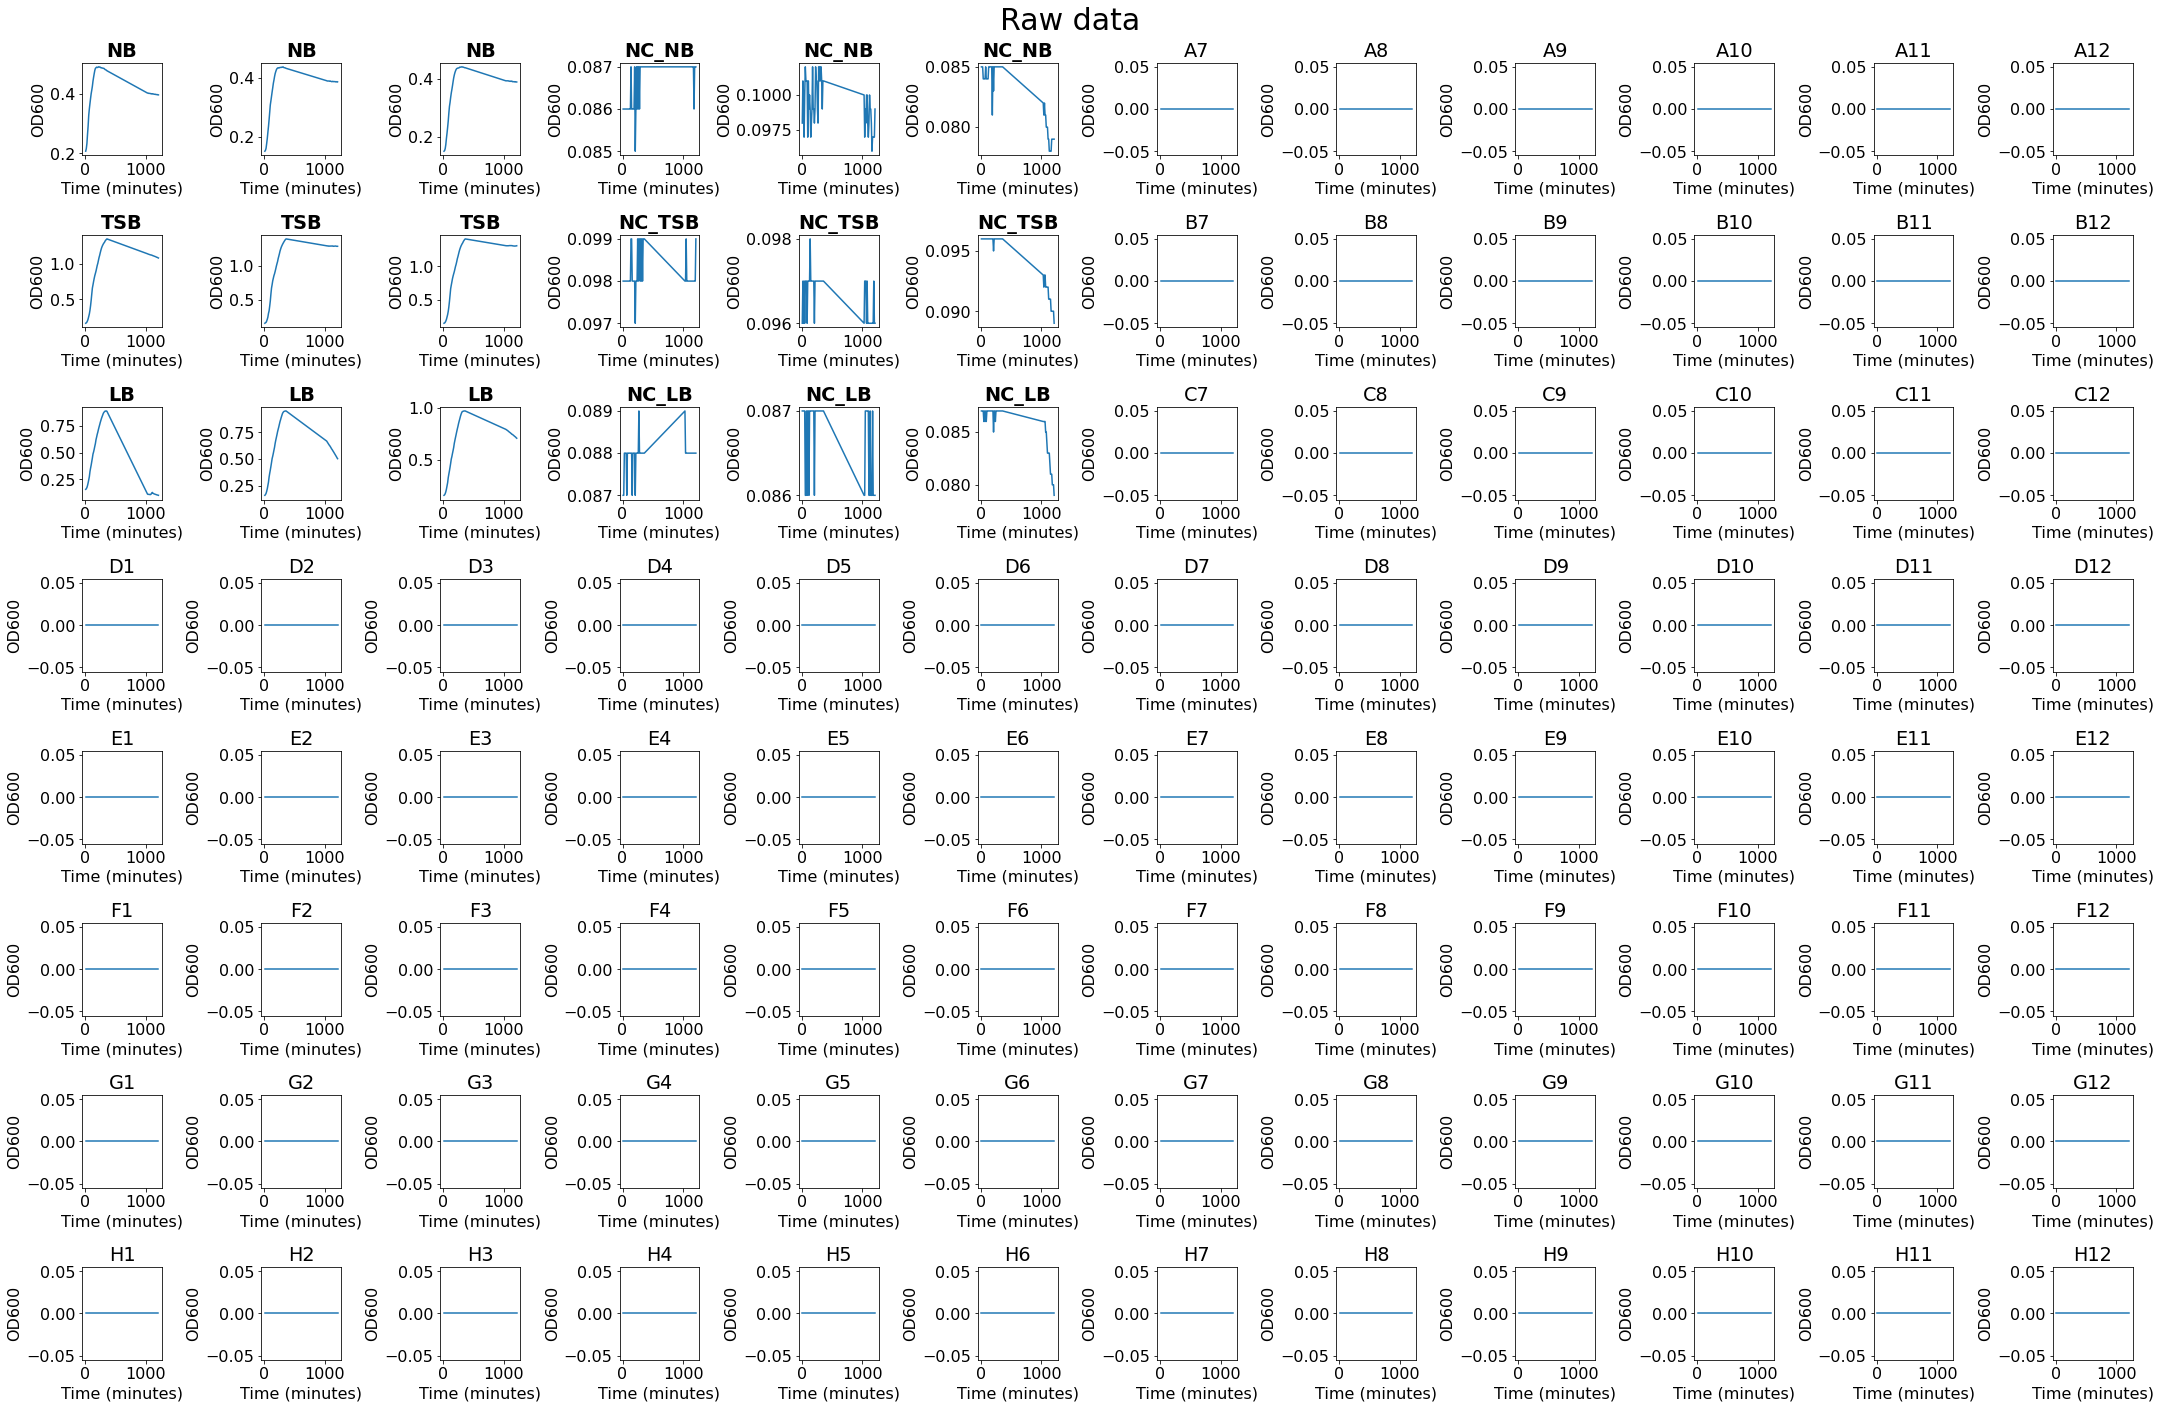

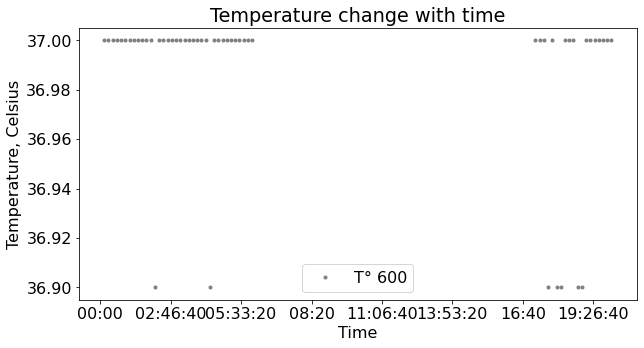

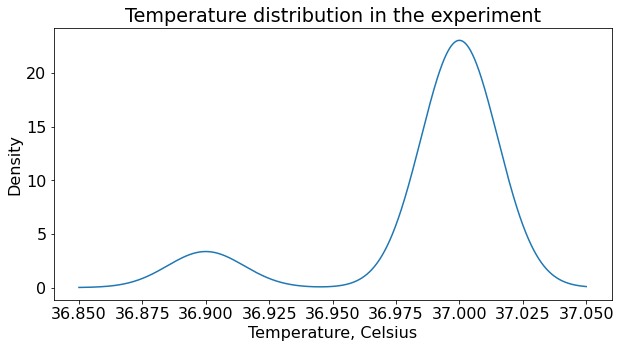

In [18]:
# general plots

# plot all the wells in subplots to look like the plate
def plotPlate(plate, title):
    
    # plots multiple subplots of  a given dataframe
    i=0
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    for col in plate.columns:
        if any(x in col for x in['Time','T° 600','total_minutes']):
            continue  
        w=re.match("([A-Z])([0-9]+)",col)
        nrows.add(w.group(1))
        ncols.add(w.group(2))
    fig=plt.figure(figsize=(2.5*len(ncols),2.5*len(nrows)))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Add the main title
    fig.suptitle(title, fontsize=30)
    for col in plate.columns:
        # skip the time and temperature column
        if any(x in col for x in['Time','T° 600','total_minutes']):
            continue    
        # go down a row every 12 wells
        i+=1
        '''if i%12==0:
            i=1'''
        ax=fig.add_subplot(len(nrows),len(ncols),i)
        ax.plot(plate['total_minutes'], plate[col])
        if col in col2sample:
            plt.title(col2sample[col],fontweight="bold")
        else:
            plt.title(col)
        plt.xlabel('Time (minutes)')
        plt.ylabel('OD600')
    plt.tight_layout()
    plt.savefig(graphicspath+'/'+title+'_'+filename +'.svg')
    plt.show()

plotPlate(expdf,'Raw data')       

# temperature distribution across time
cnames=expdf.columns

expdf.plot(x=cnames[0], y=cnames[1], figsize=(10,5), color='grey',style=".")
plt.title('Temperature change with time')
plt.ylabel('Temperature, Celsius')
plt.savefig(graphicspath+'/tempvstime_'+filename+'.svg')
plt.show()

plt.figure()
expdf[cnames[1]].plot.kde(figsize=(10,5), title='Temperature distribution in the experiment')
plt.xlabel('Temperature, Celsius')
plt.savefig(graphicspath+'/temp_dist_'+filename+'.svg')
plt.show()



# Blank subtraction
After reading the plate, identify samples by loading a sample file

55it [00:00, 3943.03it/s]


<Figure size 432x288 with 0 Axes>

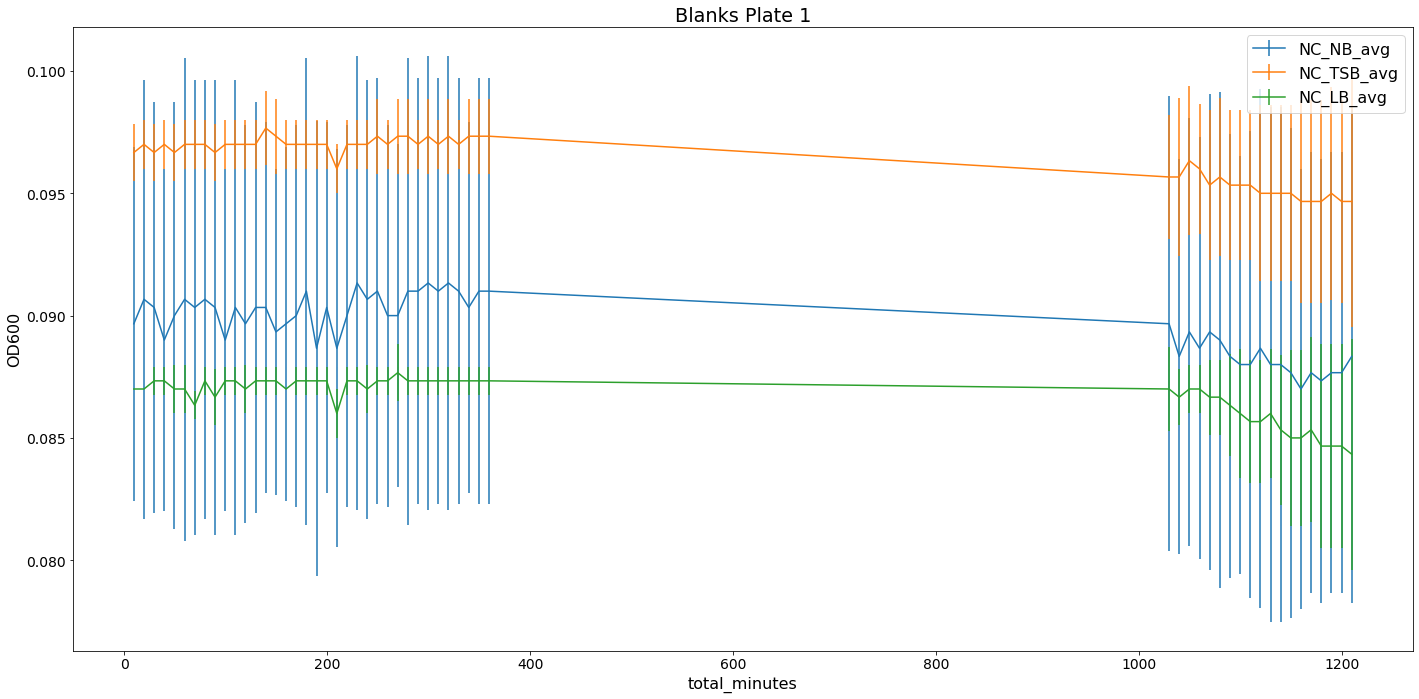

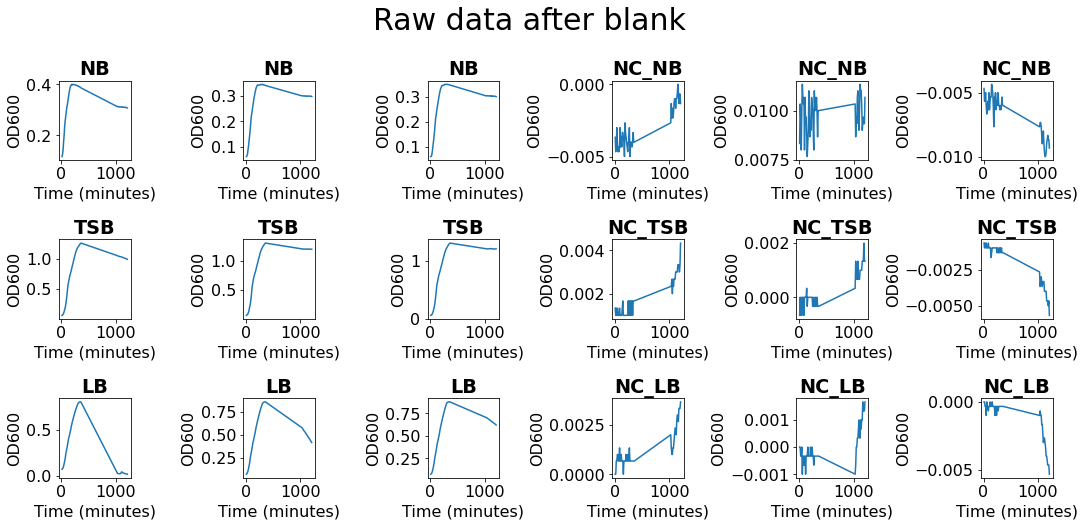

<Figure size 432x288 with 0 Axes>

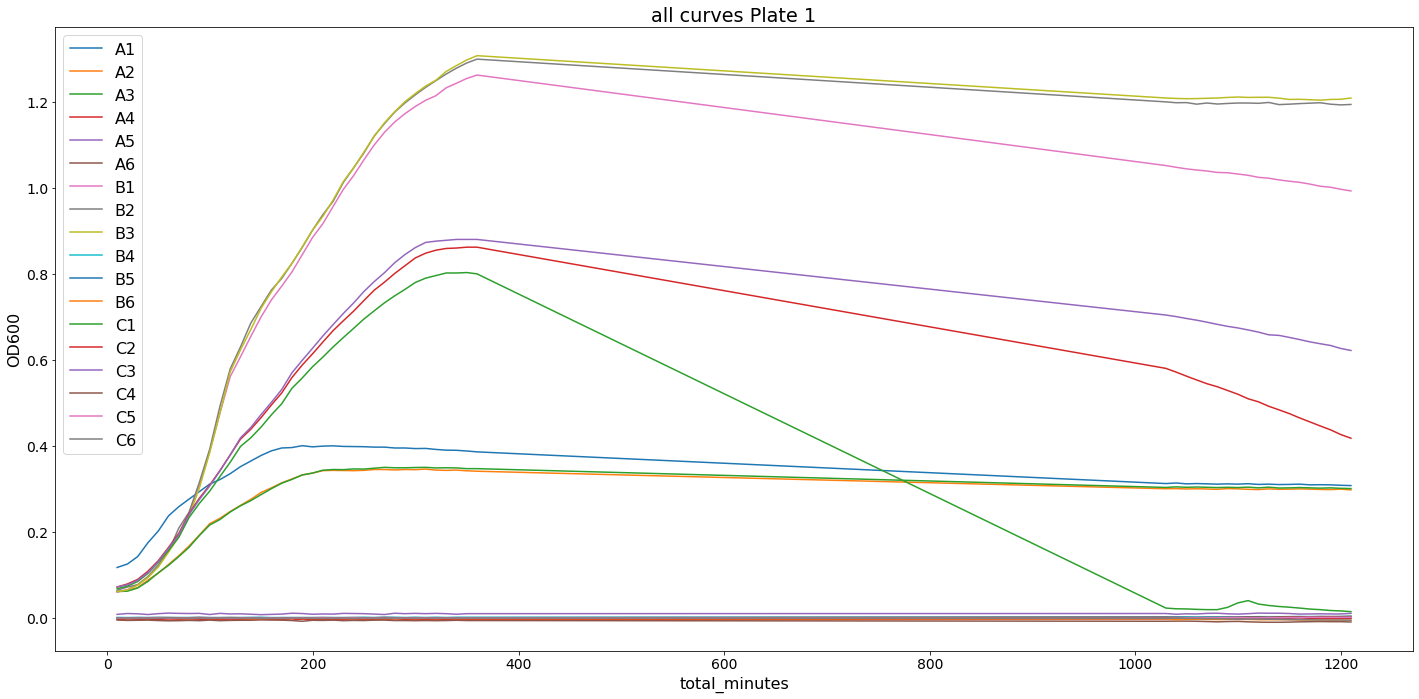

total_minutes        A1        A2        A3        A4        A5        A6  \
0            9.55  0.117333  0.061333  0.061333 -0.003667  0.008333 -0.004667   
1           19.55  0.125333  0.063333  0.062333 -0.004667  0.010333 -0.005667   
2           29.55  0.142667  0.070667  0.069667 -0.004333  0.009667 -0.005333   
3           39.55  0.175000  0.088000  0.085000 -0.003000  0.008000 -0.005000   
4           49.55  0.202000  0.104000  0.105000 -0.004000  0.010000 -0.006000   
5           59.55  0.237333  0.124333  0.122333 -0.004667  0.011333 -0.006667   
6           69.55  0.258667  0.144667  0.142667 -0.004333  0.010667 -0.006333   
7           79.55  0.276333  0.167333  0.164333 -0.004667  0.010333 -0.005667   
8           89.55  0.293667  0.192667  0.191667 -0.004333  0.010667 -0.006333   
9           99.55  0.311000  0.219000  0.216000 -0.003000  0.008000 -0.005000   
10         109.55  0.321667  0.231667  0.228667 -0.004333  0.010667 -0.006333   
11         119.55  0.335333  0.247333  0.246333 -0.003667  0.009333 -0.005667   
12         129.55  0.351667  0.261667  0.260667 -0.004333  0.009667 -0.005333   
13         139.55  0.364667  0.275667  0.272667 -0.003333  0.008667 -0.005333   
14         149.55  0.377667  0.291667  0.286667 -0.003333  0.007667 -0.004333   
15         159.55  0.388333  0.302333  0.300333 -0.003667  0.008333 -0.004667   
16         169.55  0.395000  0.314000  0.313000 -0.004000  0.009000 -0.005000   
17         179.55  0.396000  0.323000  0.322000 -0.005000  0.011000 -0.006000   
18         189.55  0.400333  0.332333  0.332333 -0.002667  0.010333 -0.007667   
19         199.55  0.397667  0.336667  0.336667 -0.003333  0.008667 -0.005333   
20         209.55  0.399333  0.342333  0.343333 -0.003667  0.009333 -0.005667   
21         219.55  0.400000  0.343000  0.345000 -0.004000  0.009000 -0.005000   
22         229.55  0.398667  0.342667  0.344667 -0.004333  0.010667 -0.006333   
23         239.55  0.398333  0.342333  0.346333 -0.004667  0.010333 -0.005667   
24         249.55  0.398000  0.343000  0.346000 -0.004000  0.010000 -0.006000   
25         259.55  0.397000  0.345000  0.348000 -0.004000  0.009000 -0.005000   
26         269.55  0.397000  0.345000  0.350000 -0.003000  0.008000 -0.005000   
27         279.55  0.395000  0.344000  0.349000 -0.005000  0.011000 -0.006000   
28         289.55  0.395000  0.345000  0.349000 -0.004000  0.010000 -0.006000   
29         299.55  0.393667  0.344667  0.349667 -0.004333  0.010667 -0.006333   
30         309.55  0.394000  0.346000  0.350000 -0.004000  0.010000 -0.006000   
31         319.55  0.391667  0.343667  0.348667 -0.004333  0.010667 -0.006333   
32         329.55  0.390000  0.343000  0.349000 -0.004000  0.010000 -0.006000   
33         339.55  0.389667  0.343667  0.348667 -0.003333  0.008667 -0.005333   
34         349.55  0.388000  0.342000  0.347000 -0.004000  0.010000 -0.006000   
35         359.55  0.386000  0.341000  0.347000 -0.004000  0.010000 -0.006000   
36        1029.55  0.312333  0.300333  0.303333 -0.002667  0.010333 -0.007667   
37        1039.55  0.313667  0.300667  0.304667 -0.001333  0.008667 -0.007333   
38        1049.55  0.311667  0.299667  0.303667 -0.002333  0.009667 -0.007333   
39        1059.55  0.312333  0.300333  0.304333 -0.001667  0.009333 -0.007667   
40        1069.55  0.311667  0.299667  0.303667 -0.002333  0.010667 -0.008333   
41        1079.55  0.311000  0.299000  0.303000 -0.002000  0.011000 -0.009000   
42        1089.55  0.311667  0.300667  0.303667 -0.001333  0.009667 -0.008333   
43        1099.55  0.311000  0.300000  0.303000 -0.001000  0.009000 -0.008000   
44        1109.55  0.312000  0.299000  0.304000 -0.001000  0.010000 -0.009000   
45        1119.55  0.310333  0.298333  0.302333 -0.001667  0.011333 -0.009667   
46        1129.55  0.311000  0.300000  0.304000 -0.001000  0.011000 -0.010000   
47        1139.55  0.310000  0.299000  0.302000 -0.001000  0.011000 -0.010000   
48        1149.55  0.310333  0.2993

In [19]:
# subtract blanks
# this will have the output table
workdf = pd.DataFrame()
cleandf=pd.DataFrame()
wd={}
cdict={}
nc_err_names=[]
nc_avg_names=set()
ncdict = {}
blank2samples={}
# ---------------analyze plate---------------------------

# plot all the wells in both semilog (y) and regular plots

for i, tp in tqdm(expdf.iterrows()):
    ncdict[tp['total_minutes']] = {}
    wd[tp['total_minutes']]={}
    cdict[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # blanks
    for b in blanks:
        curcols=[]
        vals=[]
        for nc in blanks[b]:
            vals.append(tp[nc])
        nc_avg=statistics.mean(vals)
        nc_stdev=statistics.stdev(vals)
        nca_name = b+'_avg'
        ncs_name = b+'_stdev'
        ncdict[tp['total_minutes']][nca_name] = nc_avg
        ncdict[tp['total_minutes']][ncs_name] = nc_stdev
        nc_err_names.append(ncs_name)
        nc_avg_names.add(nca_name)
        
        # find the columns matching the blank, the blanks are named NC_sample
        bsample=b.split('_')
        cursample=bsample[1].strip()
        # get the column list for the matching sample
        curcols=samples[cursample]
        blank2samples[b]=curcols
        
        # create a clean version for column selecting
        for ccol in curcols:
            #ccol_name = ccol+'_mb'
            cdict[tp['total_minutes']][ccol] =tp[ccol]-nc_avg
        # add the blank columns
        curcols=curcols+blanks[b]
        
        
        
        # subtract the blank average from each column value and keep in a new table
        
        for ccol in curcols:
            
            
            #ccol_name = ccol+'_mb'
            wd[tp['total_minutes']][ccol] =tp[ccol]-nc_avg

ncdf = pd.DataFrame.from_dict(ncdict, orient='index')
ncdf.index=ncdf.index.set_names(['total_minutes'])
ncdf.reset_index(inplace=True)

# get the new plate after subtracting the blanks - blank wells should show zero values
workdf = pd.DataFrame.from_dict(wd, orient='index')
workdf.index=workdf.index.set_names(['total_minutes'])
workdf.reset_index(inplace=True)

cleandf = pd.DataFrame.from_dict(cdict, orient='index')
cleandf.index=cleandf.index.set_names(['total_minutes'])
cleandf.reset_index(inplace=True)
# plot the blanks for a closer look


plt.figure()
plt.rcParams.update({'font.size': 16}) 
ncdf.plot(x='total_minutes',  y=list(nc_avg_names),yerr=ncdf[nc_err_names].T.values,
             figsize=(20,10),
             ylabel='OD600',
             title='Blanks '+plateid,
             #logy=True,
             fontsize=14,
             #color=colors
             )
plt.legend()
plt.tight_layout()
plt.savefig(graphicspath+'/blanks'+filename+'.svg')
plt.show()


# plot the samples after blank subtraction
plotPlate(workdf,'Raw data after blank')  


#plot all the curves on the same axis set
plt.figure()
plt.rcParams.update({'font.size': 16}) 
workdf.plot(x='total_minutes',
             figsize=(20,10),
             ylabel='OD600',
             title='all curves '+plateid,
             #logy=True,
             fontsize=14,
             #color=colors
             )
plt.legend()
plt.tight_layout()
plt.savefig(graphicspath+'/all_wells_after_blank'+filename+'.svg')
plt.show()
workdf


# Add log2 values 

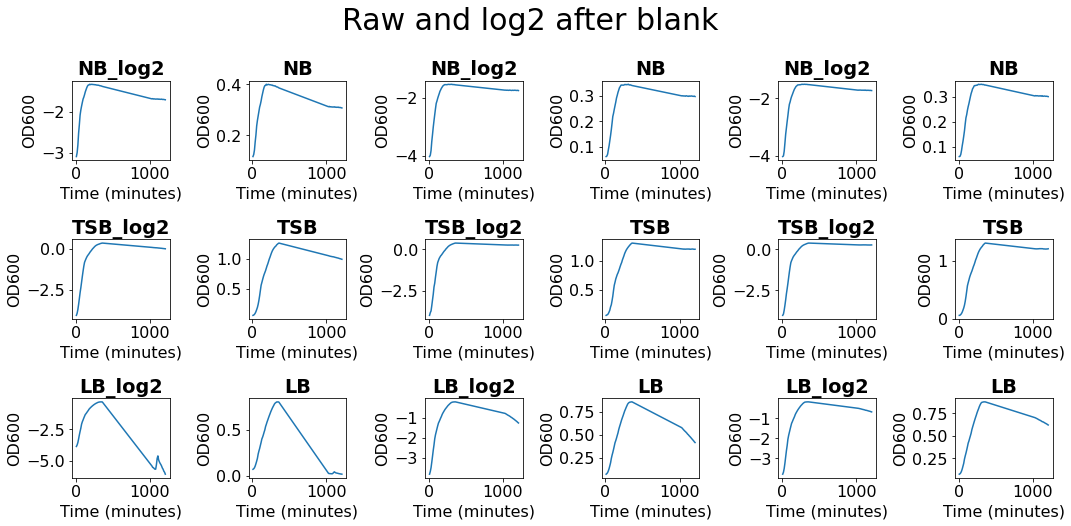

In [20]:
# add log2 values, this time no need to work with the blank columns
nsamples={}
log2tdf=pd.DataFrame()
log2tdf=pd.concat([log2tdf,workdf['total_minutes']],axis=1)
for sample in list(samples):
    if 'NC' in sample or sample in nsamples:
        continue
    # add the new sample name to the samples dictionary for easy plotting
    nsample_name=sample+'_log2'
    nsamples[nsample_name]=set()
    for well in samples[sample]:
        nwell_name=well+'00'
        nsamples[nsample_name].add(nwell_name)
        wclog2=np.log2(workdf[well].values)
        col2sample[nwell_name]=nsample_name
        # add to the table
        wclog2series=pd.Series(wclog2,name=nwell_name)
        log2tdf=pd.concat([log2tdf,wclog2series],axis=1)
        log2tdf=pd.concat([log2tdf,workdf[well]],axis=1)
# update the samples dictionary
samples.update(nsamples)

#plot the new 'plate'
plotPlate(log2tdf,'Raw and log2 after blank')  

'''# save the dataframe to a file with the sample titles
sample_names_io=['total_minutes']
for col in log2tdf.columns:
    if 'total_minutes' in col:
        continue
    sample_names_io.append(col2sample[col])
outdf=log2tdf
# change column names in output table
outdf.columns=sample_names_io
outdf.to_csv(respath+'/'+'sample_data_wlog2_'+filename+'.csv')
outdf'''
log2tdf
log2tdf.to_excel(respath+'/samples_wlog2_vals_'+filename+'.xlsx')
log2tdf.to_csv(respath+'/samples_wlog2_vals_'+filename+'.csv')

# Get metrics for all the sample wells curves

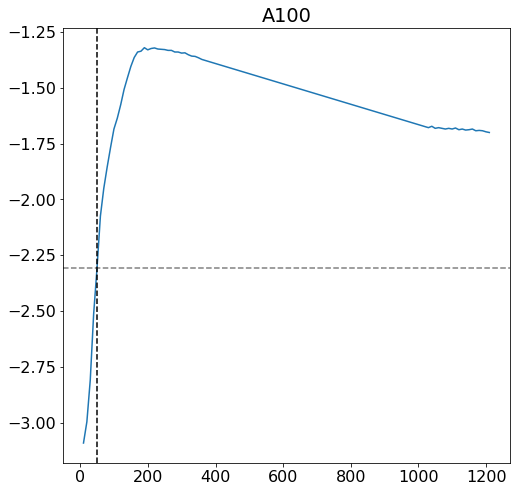

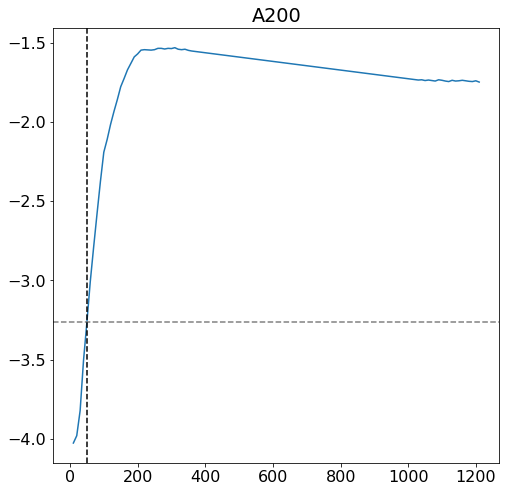

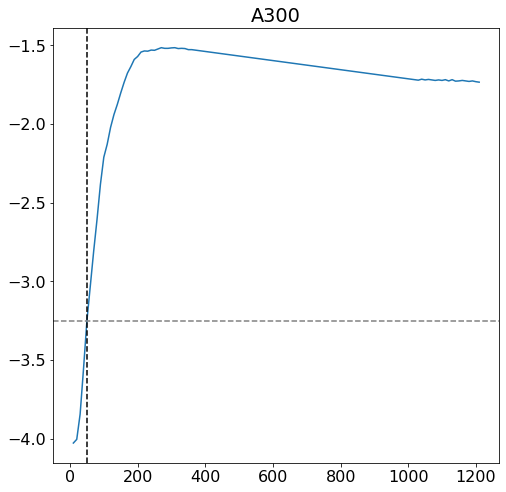

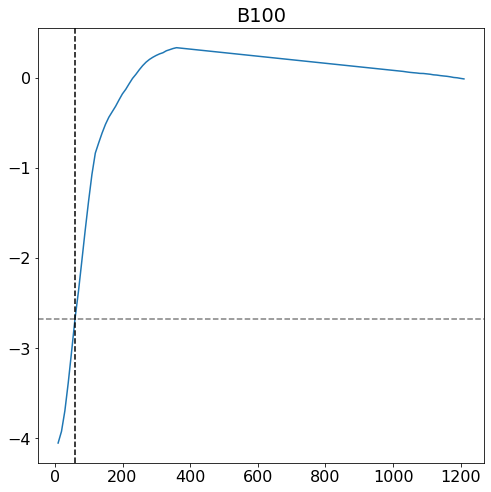

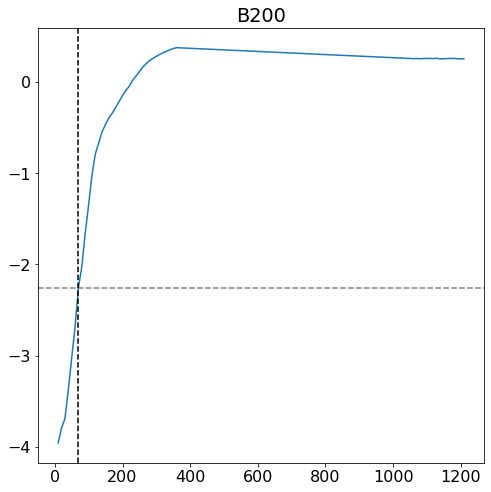

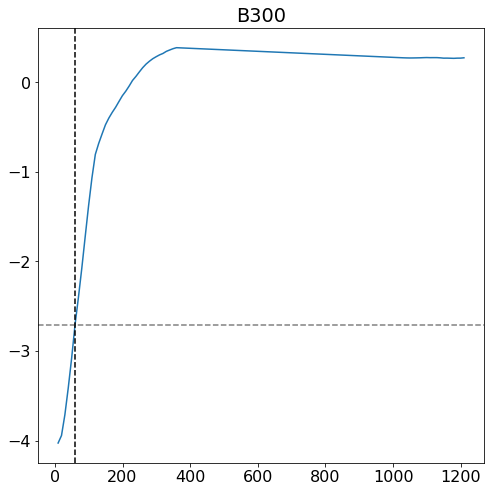

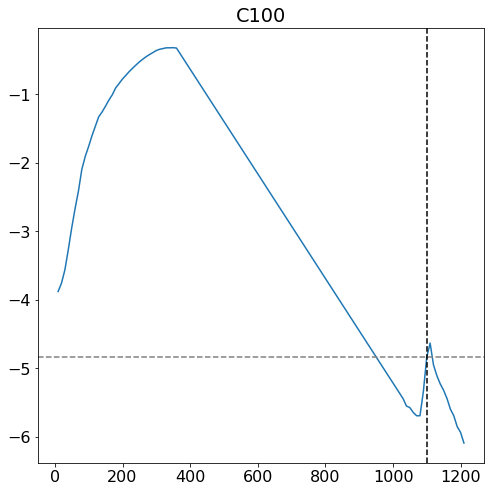

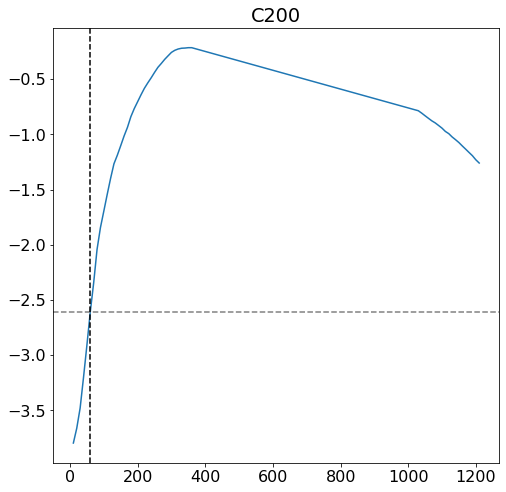

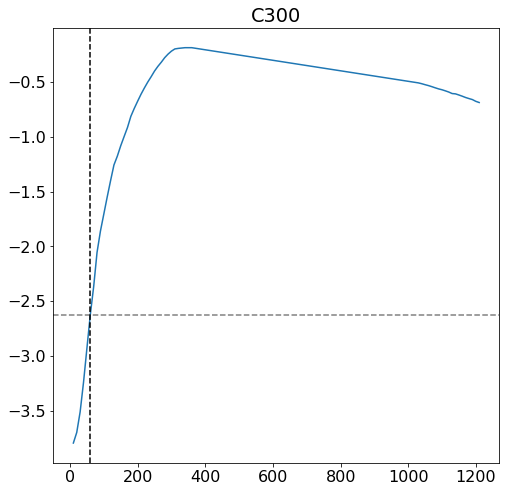

sample_name well plate_id  maxOD600  Maximum_slope  Doubling_time  \
0          NB   A1  Plate 1  0.400333       0.025085      39.863905   
1          NB   A2  Plate 1  0.346000       0.027874      35.875613   
2          NB   A3  Plate 1  0.350000       0.029592      33.792410   
3         TSB   B1  Plate 1  1.261667       0.035483      28.182580   
4         TSB   B2  Plate 1  1.298667       0.038634      25.883756   
5         TSB   B3  Plate 1  1.306667       0.035140      28.457639   
6          LB   C1  Plate 1  0.802667       0.042813      23.357268   
7          LB   C2  Plate 1  0.861667       0.029689      33.682148   
8          LB   C3  Plate 1  0.879667       0.030824      32.442596   

   Time_to_reach_maxOD600_(minutes)  Maximum_slope_OD  \
0                            189.55             0.202   
1                            309.55             0.104   
2                            269.55             0.105   
3                            359.55             0.157   
4                            359.55             0.209   
5                            359.55             0.153   
6                            349.55             0.035   
7                            349.55             0.164   
8                            339.55             0.162   

   Time_to_reach_max_slope_(minutes)  
0                              49.55  
1                              49.55  
2                              49.55  
3                              59.55  
4                              69.55  
5                              59.55  
6                            1099.55  
7                              59.55  
8                              59.55

In [21]:
# calculate maxOD and time to reach maxOD for the wells in log2tdf
# the final table will look like 
# well | maxOD | ttr_maxOD | mid_log OD | ttr_mid_logOD | growth_rate | doubeling_time

# using a max slope approach to catch the growth rate. The window for slope calculations will be 3 points.
# the time to reach max slope will be for the end point of the window.
# All slope calculations will be done on the log2 values.

def getMetrics(curve1,curve2, col):
    # returns the mid-log OD and time to reach mid log
    # uses rolling regression and R values to capture different segments of the curve
    
    # rolling regression - get the R values for a regression line in every coordinate
    # curve is a list of curve values over time - log2
    #time
    curve1_list=curve1.values.tolist()
    # log2 values
    curve2_list=curve2.values.tolist()
    window=2
    slopes = []
    intercepts = []
    Rs=[]
    windows={}
    # get the values for the window
    for c in range(len(curve1)-window):
        ogx=curve1.loc[c:c+window]
        ogy=curve2.loc[c:c+window]
        y=np.array(ogy.values.tolist())
        x=np.array(ogx.values.tolist())
        y=y.reshape(-1,1)
        x=x.reshape(-1,1)
        lr=LinearRegression()
        lr.fit(x,y)
        R_coef=lr.score(x,y)
        '''if R_coef<0.95:
            #print(col+'\t'+str(c)+' minutes')
            #print(R_coef)
            exp=c
            break'''
            
        Rs.append(R_coef)
        intercepts.append(lr.intercept_)
        slopes.append(float(lr.coef_[0]))
        # store the window indices information in a dictionary the keys will be window numbers which will correlate with slope numbers.
        # every window gets one slope and one R coefficient number
        windows[c]=c+window
        
    
    # find the index for the window that has the maximum slope
    # max_slope
    max_slope=max(slopes)
    max_slope_idx=slopes.index(max_slope)
    # get the values for the max_slope and time to max_slope
    
    
    # get the place on the general curve for fetching the time to max sloe
    max_slope_indx=windows[max_slope_idx]
    ogmax_slope_val=curve2_list[max_slope_indx]
    # inverse log 2 back to od
    max_slope_val=2**ogmax_slope_val

    ttr_max_slope=curve1_list[max_slope_indx]
        
    '''# this creates the plot for the general chunk of curve from the begining - obsolete for this version
    ogxlist=list(curve1[0:c])
    ogylist=list(curve2[0:c])
    tslope, intercept, r_value, p_value, std_err = stats.linregress(ogxlist,ogylist)    
    # plot vs. Time
    
    plt.figure(figsize=(10,10))
    ogxlist=list(curve1[0:c])
    ogylist=list(curve2[0:c])
    tslope, intercept, r_value, p_value, std_err = stats.linregress(ogxlist,ogylist)
    g=sns.regplot(x=ogxlist,y=ogylist,line_kws={'label':"y={0:.5f}x+{1:.1f}".format(tslope,intercept)})
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend()
    plt.show()'''
    
    # get the metrics
    max_slope_R=Rs[max_slope_idx]
    
    dbl_time=1/max_slope
    
    # plot the curve for eyballing - now add the max_slope point
    plt.figure(figsize=(8,8))
    sns.lineplot(x=curve1_list, y=curve2_list)
    plt.axhline(y=ogmax_slope_val, color='grey', linestyle='--')
    plt.axvline(x=ttr_max_slope, color='black', linestyle='--')
    plt.title(col)
    plt.show()
    
    
    
    return max_slope,max_slope_val, dbl_time,ttr_max_slope, max_slope_R



fpopdf=pd.DataFrame()
for col in log2tdf.columns:
    if not '00' in col or 'total_minutes' in col:
        continue
    # get the values for the maxOD, midlog, growth rate and doubling time
    max_slope,max_slope_od,dbt,ttr_max_slope,max_slop_R=getMetrics(log2tdf['total_minutes'],log2tdf[col],col)
    # use the indices to get the values from the series
    # for max OD I need to use the original columns
    ogcol=col.replace('00','')
    ogcol_list=list(log2tdf[ogcol].values)
    max_od=max(log2tdf[ogcol].values)
    # get the values for ttr_maxOD,and ttr to midlog
    ttr_max_idx=log2tdf.index[log2tdf[ogcol]==max_od].values
    ttr_max_idx=ttr_max_idx[0]
    ttr_max_od=log2tdf.loc[ttr_max_idx]['total_minutes']
    
    # update the table
    values_to_add = {'sample_name':col2sample[ogcol],'well': ogcol,'plate_id':plateid,'maxOD600':max_od,
                     'Maximum_slope':max_slope,'Doubling_time':dbt,'Time_to_reach_maxOD600_(minutes)':ttr_max_od,
                     'Maximum_slope_OD':max_slope_od,'Time_to_reach_max_slope_(minutes)':ttr_max_slope }
    row_to_add = pd.Series(values_to_add, name=ogcol)
    new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
    fpopdf = pd.concat([fpopdf,new_df],ignore_index=True)
    
fpopdf
    
    

# Plot the plate in a per metric look for column selection

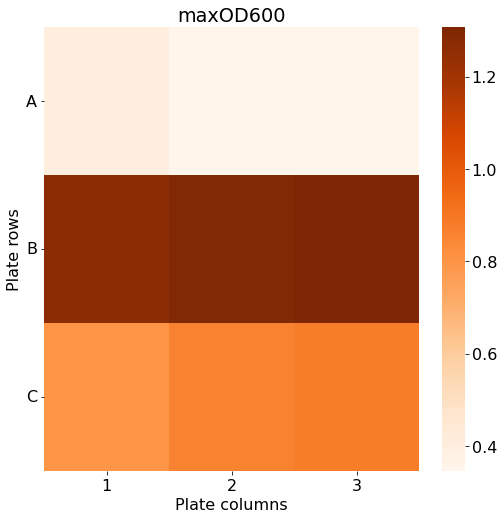

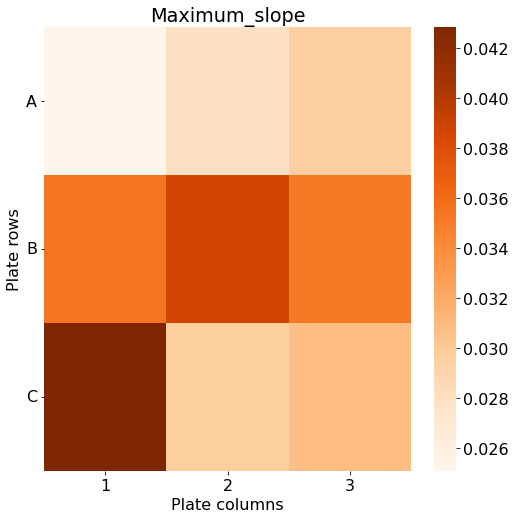

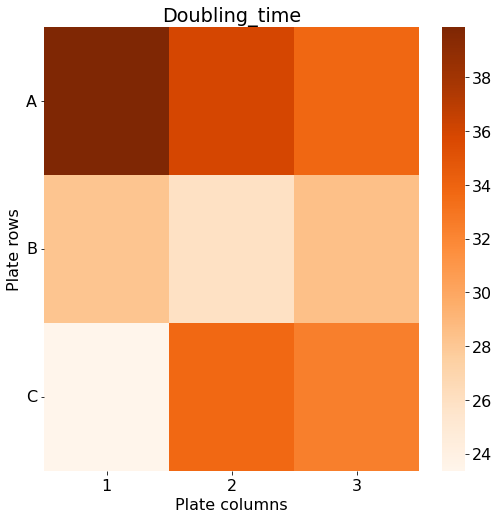

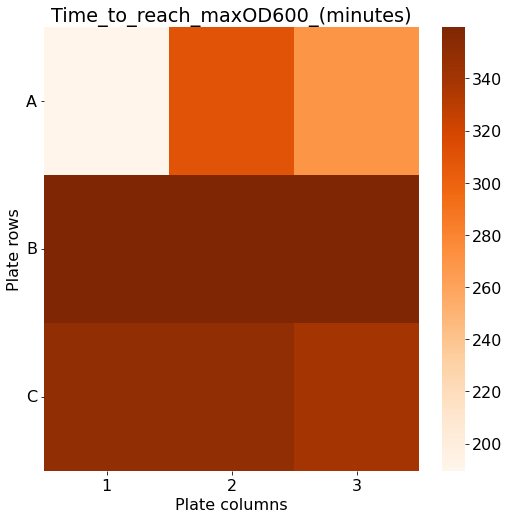

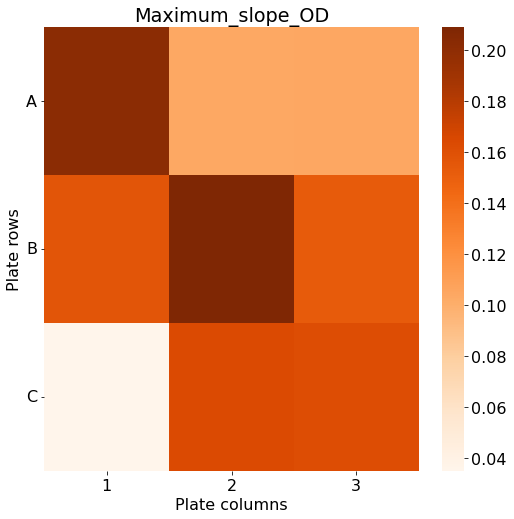

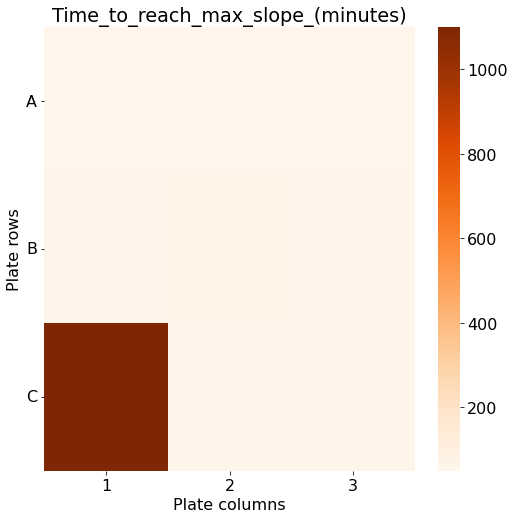

In [22]:
# plot a single metric look of the samples
def plotPlateSM(plate,metric):
    
    # plot a heatmap of the sample/well vs a metric
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    
    tempdict={}
    tempdf=pd.DataFrame()
    vals=[]
    letters=[]
    numbers=set()
    for col in plate['well']:
        # skip the time and temperature column
        '''if any(x in col for x in['sample_name']):
            continue'''   
        w=re.match("([A-Z])([0-9]+)",col)
        letter=w.group(1)
        nrows.add(letter)
        num=w.group(2)
        numbers.add(num)
        met_idx=plate.index[plate['well']==col].values
        met_idx=met_idx[0]
        val=plate.loc[met_idx][metric]
        if letter not in tempdict:
            tempdict[letter]=[]
        tempdict[letter].append(val)
        
    numbers=list(sorted(numbers))    
    # build the df por plotting
    tempdf=pd.DataFrame.from_dict(tempdict, orient='index',columns=numbers)
    # plot
    plt.figure(figsize=(2.5*len(numbers),2.5*len(nrows)))
    ax=sns.heatmap(tempdf, cmap='Oranges')
    ax.tick_params(axis='y', rotation=0)
    plt.title(metric)
    plt.ylabel('Plate rows')
    plt.xlabel('Plate columns')
    plt.tight_layout()
    plt.savefig(graphicspath+'/'+metric+'_'+filename +'.svg')
    plt.show()          
# plot all the metrics in the fpopdf table
for met in fpopdf.columns:
    # skip the metadata
    if any(x in met for x in ['sample_name','well','plate_id']):
        continue
    plotPlateSM(fpopdf,met)

# Select columns to remove from the table
The code will drop two columns for each choice - one for the od values and one for the log2 values

In [10]:
# select columns to remove from a dataframe - using a clean version of the data without the log2
# creating a widget for viewing the dataframe

app = JupyterDash(__name__)
# Load Data
df = cleandf
# Build App
app.layout = html.Div([
            dash_table.DataTable(
                id='table',
                columns=[
                {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
                ],
                data=df.to_dict('records'),
                editable=True,
                filter_action="native",
                sort_action="native",
                sort_mode="multi",
                column_selectable="multi",
                row_selectable="multi",
                row_deletable=True,
                selected_columns=[],
                selected_rows=[],
                page_action="native",
                page_current= 0,
                page_size= 10,
            ),
            html.Div(id='datatable-interactivity-container'),
            html.Button(id="save-button",n_clicks=0,children="Save"),
            html.Div(id="output-1",children="Press button to save changes")
])

@app.callback(
        Output("output-1","children"),
        [Input("save-button","n_clicks")],
        [State("table","data")]
        )

def selected_data_to_csv(nclicks,table1): 
    if nclicks == 0:
        raise PreventUpdate
    else:
        pd.DataFrame(table1).to_csv(respath+'/interim_df.csv',index=False)
        return "Data processed, continue running notebook"

# Run app and display result inline in the notebook
app.run_server(mode='inline', debug=True)



# Continue analyzing with consolidated, cleaned data

Plotting the growth curves

In [23]:
# get the updated dataframe
graphdf=pd.read_csv(respath+'/interim_df.csv')

#remove the interim file
os.remove(respath+'/interim_df.csv')
sample2col={}
# update the parameter table after deletion of columns
# now the columns are stored in the well column in the parameter table
# get the updated column list
ucol_list=list(graphdf.columns)
for cc in list(fpopdf['well']):
    if cc not in ucol_list:
        fpopdf.drop(fpopdf[fpopdf['well']==cc].index,inplace=True)
        
# create an update sample2col mapping
for cc in list(fpopdf['well']):
    dfline=fpopdf[fpopdf['well']==cc]
    sample=dfline['sample_name'].values
    sample=sample[0]
    if sample not in sample2col:
        sample2col[sample]=set()
    sample2col[sample].add(cc)
    
fpopdf
        

sample_name well plate_id  maxOD600  Maximum_slope  Doubling_time  \
0          NB   A1  Plate 1  0.400333       0.025085      39.863905   
1          NB   A2  Plate 1  0.346000       0.027874      35.875613   
2          NB   A3  Plate 1  0.350000       0.029592      33.792410   
3         TSB   B1  Plate 1  1.261667       0.035483      28.182580   
4         TSB   B2  Plate 1  1.298667       0.038634      25.883756   
5         TSB   B3  Plate 1  1.306667       0.035140      28.457639   
6          LB   C1  Plate 1  0.802667       0.042813      23.357268   
7          LB   C2  Plate 1  0.861667       0.029689      33.682148   

   Time_to_reach_maxOD600_(minutes)  Maximum_slope_OD  \
0                            189.55             0.202   
1                            309.55             0.104   
2                            269.55             0.105   
3                            359.55             0.157   
4                            359.55             0.209   
5                            359.55             0.153   
6                            349.55             0.035   
7                            349.55             0.164   

   Time_to_reach_max_slope_(minutes)  
0                              49.55  
1                              49.55  
2                              49.55  
3                              59.55  
4                              69.55  
5                              59.55  
6                            1099.55  
7                              59.55

# Consolidate curve and parameter data
Calculate the average and standard deviation of sample using the wells that are left.

121it [00:00, 6696.45it/s]


<Figure size 432x288 with 0 Axes>

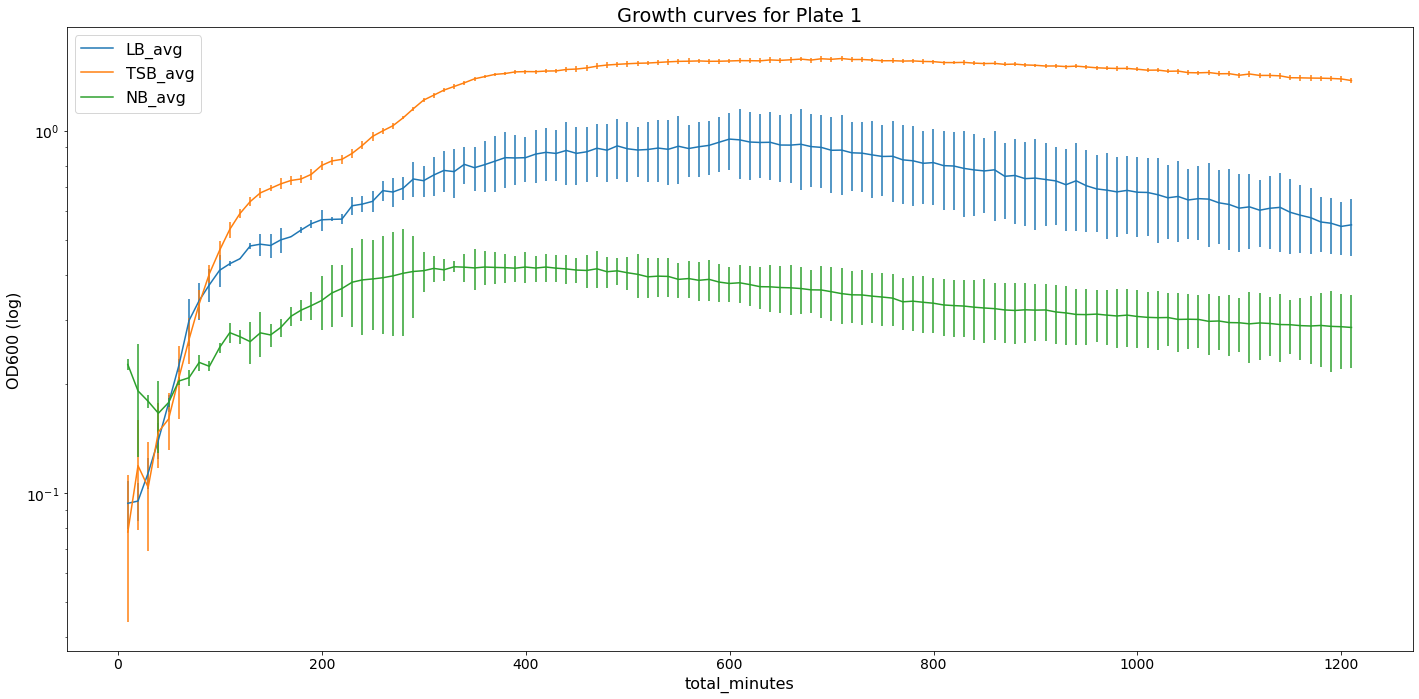

<Figure size 432x288 with 0 Axes>

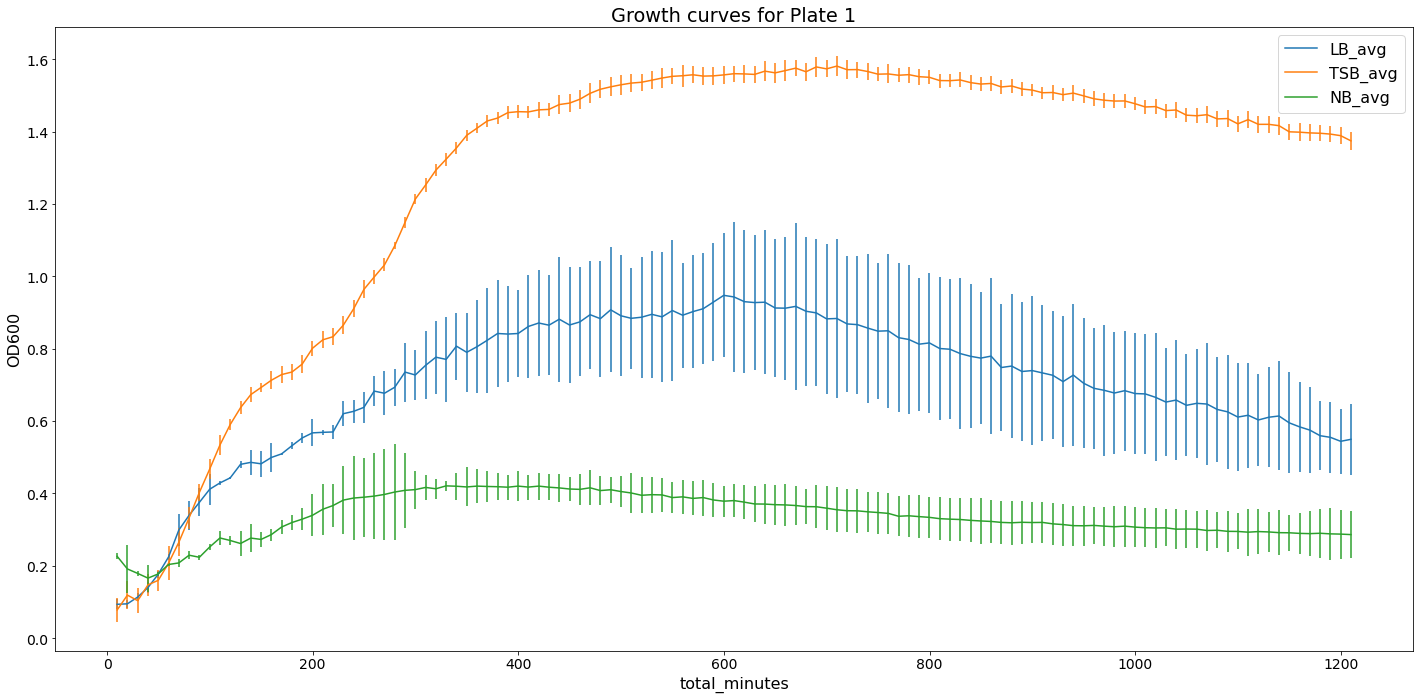

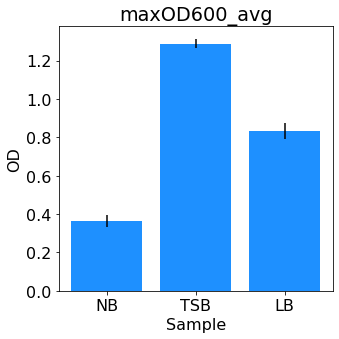

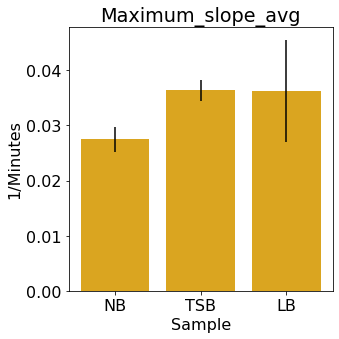

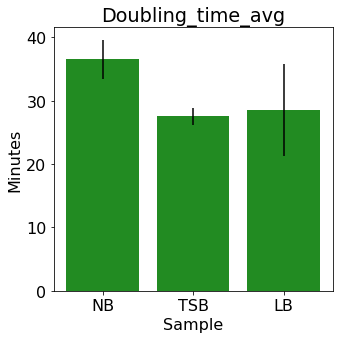

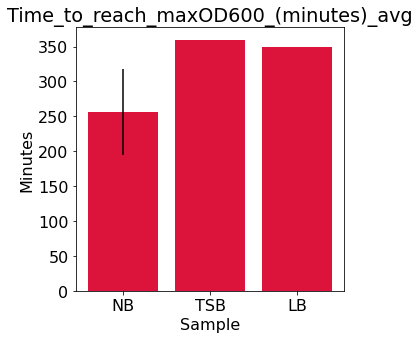

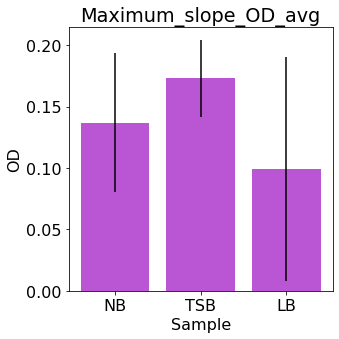

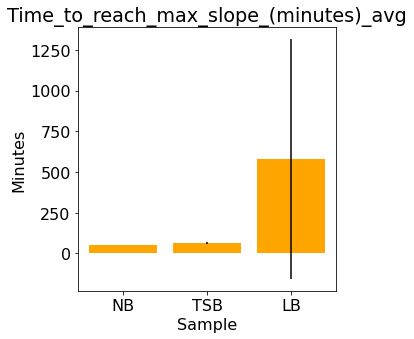

In [25]:
# start with the curves

wd={}
s_err_names=set()
s_avg_names=set()
for i, tp in tqdm(graphdf.iterrows()):
    wd[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        vals=[]
        for well in sample2col[s]:
            vals.append(tp[well])
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = s+'_avg'
        nst_name = s+'_stdev'
        wd[tp['total_minutes']][ns_name] = s_avg
        wd[tp['total_minutes']][nst_name] = s_stdev
        s_err_names.add(nst_name)
        s_avg_names.add(ns_name)
stl=list(s_err_names)
sl=list(s_avg_names)
ngraphdf = pd.DataFrame.from_dict(wd, orient='index')
ngraphdf.index=ngraphdf.index.set_names(['total_minutes'])
ngraphdf.reset_index(inplace=True)


#plot
plt.figure()
plt.rcParams.update({'font.size': 16}) 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(20,10),
             ylabel='OD600 (log)',
             title='Growth curves for '+plateid,
             logy=True,
             fontsize=14,
             )

plt.tight_layout()
plt.savefig(graphicspath+'/growth_curves_'+filename+'.svg')
plt.show() 

# plot regular axis
#plot
plt.figure()
plt.rcParams.update({'font.size': 16}) 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(20,10),
             ylabel='OD600',
             title='Growth curves for '+plateid,
             #logy=True,
             fontsize=14,
             )

plt.tight_layout()
plt.savefig(graphicspath+'/growth_curves_regaxis_'+filename+'.svg')
plt.show() 

# now do the parameters

wpd={}
errdict={}

for col in fpopdf.columns:
    
    if any(x in col for x in ['sample_name', 'well','plate_id']):
        continue
    # now we have the parameters columns and we can go over the samples and get the values
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        if s not in wpd:
            wpd[s]={}
        vals=[]
        for well in sample2col[s]:
            # get the index of the well
            idx=fpopdf.index[fpopdf['well']==well].values
            idx=idx[0]
            val=fpopdf.loc[idx][col]
            vals.append(val)
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = col+'_avg'
        nst_name = col+'_stdev'
        wpd[s][ns_name] = s_avg
        wpd[s][nst_name] = s_stdev
        errdict[ns_name]=nst_name

npdf = pd.DataFrame.from_dict(wpd, orient='index')
npdf.index=npdf.index.set_names(['sample'])
npdf.reset_index(inplace=True)
mcolors=['dodgerblue','goldenrod','forestgreen','crimson','mediumorchid','orange','deepskyblue','orangered','navy','lightseagreen','deeppink']

lbdict={'maxOD600_avg': 'OD',
        'Maximum_slope_avg':'1/Minutes',
        'Doubling_time_avg':'Minutes',
        'Time_to_reach_maxOD600_(minutes)_avg':'Minutes',
        'Maximum_slope_OD_avg':'OD',
        'Time_to_reach_max_slope_(minutes)_avg':'Minutes'   
}

# parameter plots

for l,prm in enumerate(errdict):
    errs=npdf[errdict[prm]]
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 16}) 
    #sns.scatterplot(x='sample',y=prm,data=npdf, color=mcolors[l])
    #sns.catplot(x='sample', y=prm,data=npdf,ci=npdf[errdict[prm]],color=mcolors[l], kind='bar')
    plt.bar(npdf['sample'], npdf[prm],yerr=npdf[errdict[prm]], color=mcolors[l])
    plt.title(prm)
    plt.xlabel('Sample')
    plt.ylabel(lbdict[prm])
    plt.tight_layout()
    plt.savefig(graphicspath+'/params_cons'+filename+'.svg')
    plt.show()
npdf.to_excel(respath+'/params_results_'+filename+'.xlsx')
npdf.to_csv(respath+'/params_results_'+filename+'.csv')

# Heatmap views of the data 

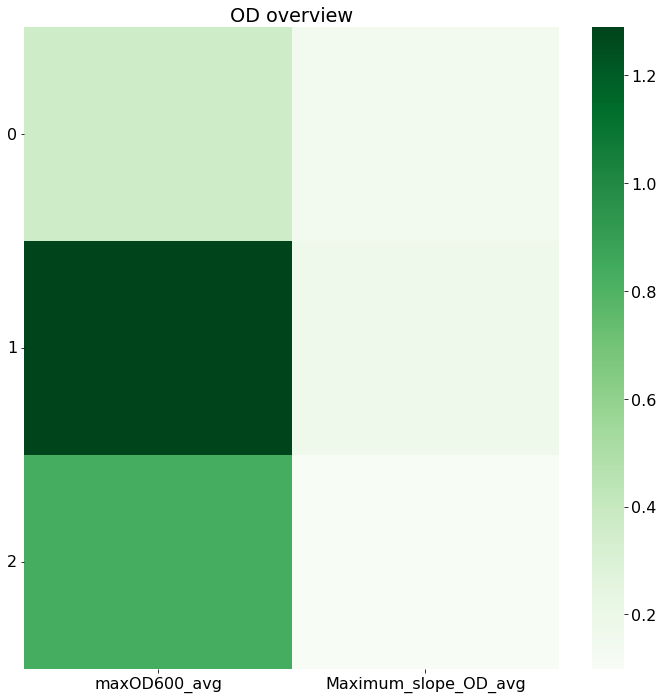

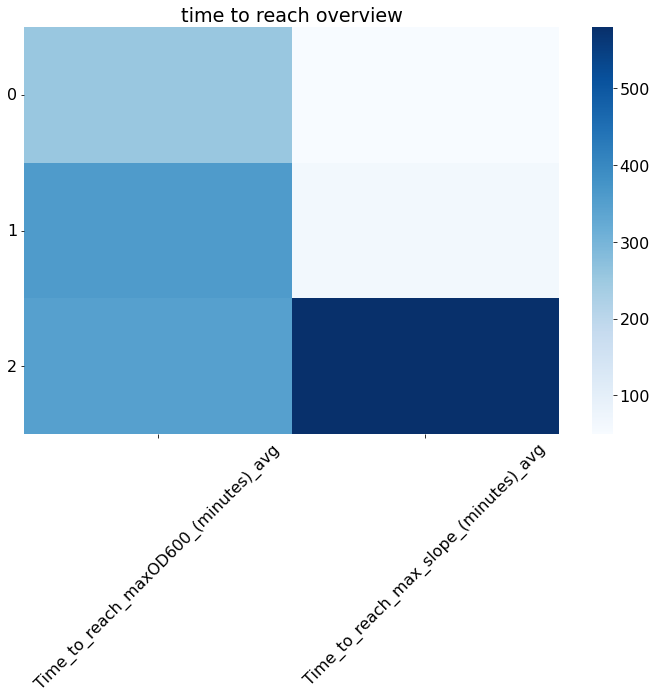

In [26]:
# max od heatmap
plotdf=npdf[['maxOD600_avg','Maximum_slope_OD_avg']]
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Greens')
ax.tick_params(axis='y', rotation=0)
plt.title('OD overview')
plt.tight_layout()
plt.savefig(graphicspath+'/od_heatmap_'+filename+'.svg')
plt.show()

# time to reach
plotdf=npdf[['Time_to_reach_maxOD600_(minutes)_avg','Time_to_reach_max_slope_(minutes)_avg']]
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Blues')
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='x',rotation=45)
plt.title('time to reach overview')
plt.tight_layout()
plt.savefig(graphicspath+'/ttr_heatmap_'+filename+'.svg')
plt.show()